# CE-40717: Machine Learning

## HW4-MultiLayer Perceptron (MLP)

[<img src="./images/ML2021S-HW4.jpg" width=1111>](https://quera.ir/assignment/28686/get_pdf_file)

---
---

The following lines of code will load the [MNIST](http://yann.lecun.com/exdb/mnist/) data and turn them
into numpy arrays, you can print their shape if you like.
You can also transform the data as you wish, including seperating
the training data for cross validation.

If you have the data (on google drive or locally) change the root
address accordingly, if you don't, set download=True but you might encounter
some problems downloading the data.

In [1]:
import torchvision.datasets as ds
import numpy as np

data_train = np.array(ds.MNIST(root="./data", train=True, download=True).data)
target_train = np.array(ds.MNIST(root="./data", train=True, download=True).targets)
data_test = np.array(ds.MNIST(root="./data", train=False, download=True).data)
target_test = np.array(ds.MNIST(root="./data", train=False, download=True).targets)

#### Transform the data! ####
data_test = data_test.reshape(data_test.shape[0], -1)
data_train = data_train.reshape(data_train.shape[0], -1)

### Part1:
Complete the functions of the MLP class to create
a MultiLayer Perceptron

In [2]:
class MLP:
    def __init__(self, in_dimensions, out_dimensions):
        self.w1 = np.random.normal(size=(in_dimensions, 512)) / in_dimensions
        self.b1 = np.random.normal(size=(1,512)) / in_dimensions
        self.w2 = np.random.normal(size=(512,out_dimensions)) / in_dimensions
        self.b2 = np.random.normal(size=(1,out_dimensions)) / in_dimensions

    def forward(self, x):
        # perform a forward pass of the network and return the result
        # remember to retain the value of each node (i.e. self.h1_forward)
        # in order to use in backpropagation
        # Use whatever activation function you wish for the first layer,
        # and softmax activation for the output layer
        self.x = x
        self.h1 = np.matmul(x, self.w1) + self.b1 # N * 512
        self.h1_a = np.maximum(self.h1, np.zeros_like(self.h1)) # N * 512
        self.h2 = np.matmul(self.h1_a, self.w2) + self.b2 # N * 10
        self.o = np.exp(self.h2) / np.sum(np.exp(self.h2), axis=1).reshape(x.shape[0],1) # N * 10
        return self.o

    def backward(self, loss, y):
        # perform backpropagation on the loss value and compute the gradient
        # w.r.t. every element of the network and retain them (i.e. self.w1_backward)
        # don't forget to consider the regularization
        one_hot = np.zeros((y.size, 10))
        one_hot[np.arange(y.size), y] = 1
        self.h2_backward = self.o - one_hot
        self.w2_backward = np.matmul(self.h1_a.T, self.h2_backward)
        self.b2_backward = np.sum(self.h2_backward, axis=0)
        self.h1_a_backward = np.matmul(self.h2_backward, self.w2.T)
        self.h1_backward =  (np.where(self.h1 > 0, self.h1_a_backward, np.zeros_like(self.h1_a_backward)))
        #print(self.h1_a_backward)
        self.b1_backward = np.sum(self.h1_backward, axis=0)
        self.w1_backward = np.matmul(self.x.T, self.h1_backward)

    def step(self, lr, lam):
        # simply update all the weights using the gradinets computed in backward
        # and the given learning rate with SGD
        self.w1 -= lr*(self.w1_backward + 2 * lam * self.w1)
        self.b1 -= lr*(self.b1_backward + 2 * lam * self.b1)
        self.w2 -= lr*(self.w2_backward + 2 * lam * self.w2)
        self.b2 -= lr*(self.b2_backward + 2 * lam * self.b2)

### Part2:
Make instances of your network and train them **using l2 regularization and choose the lambda using k-fold cross validation
(set the candidate lambda as you wish)**.

You may choose the hyperparameters (i.e. num of epochs, learning rate etc.)
as you wish. 

Then train a final model on all the training data with the chosen lambda.


In [3]:
n_epochs = 30
lr = 1e-8
k = 10
fold_len = int(data_train.shape[0]/k)
lambdas = [1, 0.1 , 0.01, 0.001] 
best_lambda = 1
best_acc = 0

for l in lambdas:
    acc = 0 # accuracy for current lambda
    loss = 0 # loss for current lambda
    for j in range(k):
        model = MLP(28**2, 10)
        train_set = np.concatenate((data_train[0: j * fold_len], data_train[(j + 1) * fold_len:])) # the training data for the current fold
        train_target = np.concatenate((target_train[0: j * fold_len], target_train[(j + 1) * fold_len:])) # the training targets for the current fold
        val_set = data_train[j * fold_len:(j + 1) * fold_len] # the validation data for the current fold
        val_target = target_train[j * fold_len:(j + 1) * fold_len] # the validation targets for the current fold

        for i in range(n_epochs):
            # train the model on the data with the curent lambda
            out = model.forward(train_set)
            loss = np.mean(-np.log(out[np.arange(train_target.size), train_target]))
            model.backward(loss, train_target)
            model.step(lr, l)

        # test the model on the current validation data
        out = model.forward(val_set)
        fold_loss = np.mean(-np.log(out[np.arange(val_target.size), val_target])) # current fold loss
        fold_acc = np.sum(np.argmax(out, axis=1) == val_target) / val_target.size # current fold accuracy
        acc += fold_acc/k
        loss += fold_loss/k

    print("Lambda:", l)
    print("Loss: %.4f Accuracy: %.4f" % (loss, acc))
    print()
    if acc > best_acc:
        best_acc = acc
        best_lambda = l

print("Best lambda is",best_lambda, "with %.4f accuracy" % best_acc)

Lambda: 1
Loss: 1.3690 Accuracy: 0.7840

Lambda: 0.1
Loss: 1.3353 Accuracy: 0.7885

Lambda: 0.01
Loss: 1.3815 Accuracy: 0.7883

Lambda: 0.001
Loss: 1.3782 Accuracy: 0.7874

Best lambda is 0.1 with 0.7885 accuracy


### Part3:
Train a final model using the best lambda on all the training data

In [4]:
n_epochs = 30
lr = 1e-8
final_model = MLP(28**2, 10)
losses = []
accs = []

for i in range(n_epochs):
    out = final_model.forward(data_train)
    loss = np.mean(-np.log(out[np.arange(target_train.size), target_train]))
    losses.append(loss)
    final_model.backward(loss, target_train)
    final_model.step(lr, best_lambda)
    acc = np.sum(np.argmax(out, axis=1) == target_train) / target_train.size
    accs.append(acc)

### Part4:

Plot the training loss value and accuracy (mean over all batches each epoch if you're using mini-batches) over epochs
for the final model that is trained on all the training data

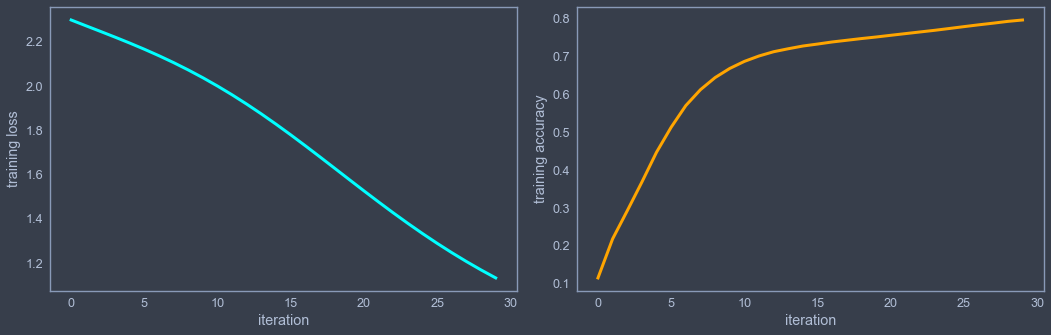

In [5]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme="onedork", context="notebook", grid=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.tight_layout(pad=2)

axes[0].plot(losses, c="cyan", lw=3)
axes[0].set_xlabel(xlabel="iteration")
axes[0].set_ylabel(ylabel="training loss")

axes[1].plot(accs, c="orange", lw=3)
axes[1].set_xlabel(xlabel="iteration")
axes[1].set_ylabel(ylabel="training accuracy");

Use your network on the test set and report the accuracy, you must get at least 70% accuracy on the test set.

In [6]:
out = final_model.forward(data_test)
acc = np.sum(np.argmax(out, axis=1) == target_test) / target_test.size
print(acc)

0.811


Below you can add code cells and improve on the network structure as you see fit (it still must be an MLP), train and test your network and explain why it works better.